<a href="https://colab.research.google.com/github/SOL1archive/KoGrammar/blob/main/baseline_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

IN_COLAB

True

In [2]:
if IN_COLAB:
    !pip install transformers
    !pip install datasets
    !pip install evaluate
    !pip install rouge_score
    !pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import os
import gc
from collections import namedtuple
from pprint import pprint
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorboard
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CyclicLR
import torchmetrics

from datasets import load_dataset, load_from_disk, concatenate_datasets, DatasetDict, Dataset
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForSeq2Seq
from transformers import BartConfig, T5Config
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Settings

In [5]:
MANUAL_TRAINING = True
MANUAL_VALIDATION = True
NUM_EPOCHS = 1
MID_CHECKPOINT_NUM = 5
MID_PROCESS_PRINT_NUM = 50

## Loading Tokenizer & Model Checkpoint

In [6]:
kobart_checkpoint = 'gogamza/kobart-base-v2'
kot5_checkpoint = 'psyche/KoT5'
kobart_baseline_checkpoint = ''
checkpoint = kobart_checkpoint
print(f'Using Checkpoint: {checkpoint}')

Using Checkpoint: gogamza/kobart-base-v2


In [7]:
if checkpoint == kobart_checkpoint:
    config = BartConfig.from_pretrained(kobart_checkpoint)
    #config['vocab'] = 30000
else:
    config = T5Config.from_pretrained(kot5_checkpoint)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [9]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, 
                                          max_length=512, 
                                          truncation=False, 
                                          padding='max_length',
                                          #vocab=config.vocab_size
                                          )
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, config=config)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [10]:
if len(tokenizer) != model.config.vocab_size:
    raise RuntimeError(f'Tokenizer vocab size and model vocab size do not match(Tokenizer:{len(tokenizer)} Model: {model.config.vocab_size}). Which would lead to further error in training.')

## Loading Datasets

In [11]:
dataset = Dataset.from_pandas(pd.read_json('drive/MyDrive/projects/KoGrammar/data/simplified_data.json'))

len(dataset)

1129363

In [12]:
train_testvalid = dataset.train_test_split(test_size=0.1)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
train_data = train_testvalid['train'].train_test_split(test_size=0.5)
dataset_dict = DatasetDict({
    'train': train_testvalid['train'],
    'train_baseline': train_data['train'],
    'train_distil': concatenate_datasets([
        train_data['train'].train_test_split(test_size=0.5)['train'],
        train_data['test'].train_test_split(test_size=0.5)['train']
    ]).shuffle(),
    'valid': test_valid['train'],
    'test': test_valid['test'],
    })

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form', '__index_level_0__'],
        num_rows: 1016426
    })
    train_baseline: Dataset({
        features: ['form', 'corrected_form', '__index_level_0__'],
        num_rows: 508213
    })
    train_distil: Dataset({
        features: ['form', 'corrected_form', '__index_level_0__'],
        num_rows: 508212
    })
    valid: Dataset({
        features: ['form', 'corrected_form', '__index_level_0__'],
        num_rows: 56468
    })
    test: Dataset({
        features: ['form', 'corrected_form', '__index_level_0__'],
        num_rows: 56469
    })
})

In [13]:
def tokenize(row):
    form_embeddings = tokenizer(row['form'], max_length=512, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        correct_form_embeddings = tokenizer(row['corrected_form'], max_length=512, truncation=True, padding='max_length')

    return {
        'input_ids': form_embeddings['input_ids'],
        'attention_mask': form_embeddings['attention_mask'],
        'labels': correct_form_embeddings['input_ids'],
    }

In [14]:
dataset_dict.keys()

dict_keys(['train', 'train_baseline', 'train_distil', 'valid', 'test'])

In [15]:
os.getcwd()

'/content'

In [16]:
replaced_checkpoint = checkpoint.replace('/', '-')
tokenized_dataset_path = f'drive/MyDrive/projects/KoGrammar/data/{replaced_checkpoint}_tokenized_dataset'

In [17]:
os.path.exists(tokenized_dataset_path)

True

In [18]:
if not os.path.exists(tokenized_dataset_path):
    tokenized_dataset = (dataset_dict
                         .map(tokenize, 
                              batched=True, 
                              batch_size=128, 
                              num_proc=10
                              )
                         .remove_columns(['form', 'corrected_form'])
                         )
    
    tokenized_dataset.save_to_disk(tokenized_dataset_path)
else:
    tokenized_dataset = load_from_disk(tokenized_dataset_path)

In [19]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1016426
    })
    train_baseline: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 508213
    })
    train_distil: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 508212
    })
    valid: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 56468
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 56469
    })
})

## Training

In [20]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='pt')

In [21]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    report_to="tensorboard",
    push_to_hub=False,
)

In [22]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['valid'],
    data_collator=data_collator,
)

In [23]:
gc.collect()
torch.cuda.empty_cache()

In [24]:
if not MANUAL_TRAINING:
    trainer.train()
else:
    total_loss_lt = []
    batch_loss_lt = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
    trainset = tokenized_dataset['train_baseline'].with_format("torch", device=device)
    dataloader = DataLoader(trainset, 
                            batch_size=35, 
                            shuffle=False, 
                            #collate_fn=lambda lt: pad_sequence(lt, 
                            #                                   batch_first=True, 
                            #                                   padding_value=tokenizer.pad_token_id
                            #                                   )
                            )
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=NUM_EPOCHS * len(dataloader))
    if not next(model.parameters()).is_cuda and device == torch.device('cuda'):
        model.to(device)
    
    model.train()
    for epoch in range(NUM_EPOCHS):
        total_steps = len(dataloader)
        save_divisor = total_steps // MID_CHECKPOINT_NUM
        print_divisor = total_steps // MID_PROCESS_PRINT_NUM
        for i, batch in enumerate(tqdm(dataloader)):
            X = {
                    'input_ids': batch['input_ids'],
                    'attention_mask': batch['attention_mask'],
                }
            y = batch['labels']
            
            outputs = model(**X, labels=y)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            #gc.collect()
            #torch.cuda.empty_cache()

            batch_loss_lt.append(loss.item())
            if i % print_divisor == print_divisor - 1:
                total_loss_lt += batch_loss_lt
                batch_loss_series = pd.Series(batch_loss_lt)
                print(f'\tbatch {i}\tloss: {loss.item()}\tmean: {batch_loss_series.mean()}')
                batch_loss_lt = []

            if i % save_divisor == save_divisor - 1:
                SAVE_STR = datetime.datetime.now().strftime('%y%m%d-%H:%M') + f'-batch{i}'
                trainer.create_model_card(
                    language='Korean',
                    tags='Grammar',
                    finetuned_from=checkpoint
                )
                trainer.save_model(f"drive/MyDrive/projects/KoGrammar/models/{SAVE_STR}")

        total_loss_lt += batch_loss_lt
        batch_loss_series = pd.Series(batch_loss_lt)
        print(f'epoch {epoch + 1} loss: {loss.item()} mean: {batch_loss_series.mean()}')

  2%|▏         | 290/14521 [05:14<4:16:45,  1.08s/it]

	batch 289	loss: 1.7700421810150146	mean: 7.367108833378759


  4%|▍         | 580/14521 [10:28<4:11:26,  1.08s/it]

	batch 579	loss: 0.17695283889770508	mean: 0.524527875513866


  6%|▌         | 870/14521 [15:42<4:06:16,  1.08s/it]

	batch 869	loss: 0.1102026179432869	mean: 0.13605358762473896


  8%|▊         | 1160/14521 [20:55<4:00:52,  1.08s/it]

	batch 1159	loss: 0.09340547025203705	mean: 0.09884510315183935


 10%|▉         | 1450/14521 [26:09<3:55:42,  1.08s/it]

	batch 1449	loss: 0.055385176092386246	mean: 0.07731878113900793


 12%|█▏        | 1740/14521 [31:23<3:50:33,  1.08s/it]

	batch 1739	loss: 0.034521881490945816	mean: 0.04551055792333751


 14%|█▍        | 2030/14521 [36:37<3:45:19,  1.08s/it]

	batch 2029	loss: 0.031153034418821335	mean: 0.033500611782073975


 16%|█▌        | 2320/14521 [41:51<3:40:02,  1.08s/it]

	batch 2319	loss: 0.023817896842956543	mean: 0.028644596477007043


 18%|█▊        | 2610/14521 [47:04<3:34:54,  1.08s/it]

	batch 2609	loss: 0.02875610813498497	mean: 0.02522871233522892


 20%|█▉        | 2900/14521 [52:18<3:29:44,  1.08s/it]

	batch 2899	loss: 0.023930836468935013	mean: 0.022396644243392452


 22%|██▏       | 3190/14521 [57:33<3:24:19,  1.08s/it]

	batch 3189	loss: 0.01721949316561222	mean: 0.020725621607411523


 24%|██▍       | 3480/14521 [1:02:48<3:19:06,  1.08s/it]

	batch 3479	loss: 0.018600530922412872	mean: 0.019104943636419444


 26%|██▌       | 3770/14521 [1:08:02<3:13:55,  1.08s/it]

	batch 3769	loss: 0.01932421326637268	mean: 0.01833972368903201


 28%|██▊       | 4060/14521 [1:13:15<3:08:39,  1.08s/it]

	batch 4059	loss: 0.015848616138100624	mean: 0.018876966011935267


 30%|██▉       | 4350/14521 [1:18:29<3:03:22,  1.08s/it]

	batch 4349	loss: 0.015503539703786373	mean: 0.01697014957216793


 32%|███▏      | 4640/14521 [1:23:43<2:58:16,  1.08s/it]

	batch 4639	loss: 0.014033067971467972	mean: 0.01551845628960893


 34%|███▍      | 4930/14521 [1:28:57<2:52:58,  1.08s/it]

	batch 4929	loss: 0.015510916709899902	mean: 0.01486107179702356


 36%|███▌      | 5220/14521 [1:34:10<2:47:46,  1.08s/it]

	batch 5219	loss: 0.018474720418453217	mean: 0.01586794251062233


 38%|███▊      | 5510/14521 [1:39:24<2:42:28,  1.08s/it]

	batch 5509	loss: 0.014761296100914478	mean: 0.013683110706765075


 40%|███▉      | 5800/14521 [1:44:38<2:37:23,  1.08s/it]

	batch 5799	loss: 0.010491366498172283	mean: 0.01308652749124529


 42%|████▏     | 6090/14521 [1:49:53<2:32:02,  1.08s/it]

	batch 6089	loss: 0.01735970750451088	mean: 0.012762788077816367


 44%|████▍     | 6380/14521 [1:55:07<2:26:47,  1.08s/it]

	batch 6379	loss: 0.01070882473140955	mean: 0.011969879475133172


 46%|████▌     | 6670/14521 [2:00:21<2:21:34,  1.08s/it]

	batch 6669	loss: 0.008621367625892162	mean: 0.011846001264799772


 48%|████▊     | 6960/14521 [2:05:35<2:16:26,  1.08s/it]

	batch 6959	loss: 0.012273476459085941	mean: 0.011622667005927912


 50%|████▉     | 7250/14521 [2:10:48<2:11:07,  1.08s/it]

	batch 7249	loss: 0.01129401195794344	mean: 0.011057371997820406


 52%|█████▏    | 7540/14521 [2:16:03<2:05:47,  1.08s/it]

	batch 7539	loss: 0.012687231414020061	mean: 0.011301945978454474


 54%|█████▍    | 7830/14521 [2:21:16<2:00:31,  1.08s/it]

	batch 7829	loss: 0.010668622329831123	mean: 0.010601173156615476


 56%|█████▌    | 8120/14521 [2:26:30<1:55:21,  1.08s/it]

	batch 8119	loss: 0.007214172277599573	mean: 0.01038348789744336


 58%|█████▊    | 8410/14521 [2:31:44<1:50:13,  1.08s/it]

	batch 8409	loss: 0.010540347546339035	mean: 0.009952647707842547


 60%|█████▉    | 8700/14521 [2:36:57<1:44:55,  1.08s/it]

	batch 8699	loss: 0.010614347644150257	mean: 0.010931268886759363


 62%|██████▏   | 8990/14521 [2:42:12<1:39:37,  1.08s/it]

	batch 8989	loss: 0.014354487881064415	mean: 0.009786590867964871


 64%|██████▍   | 9280/14521 [2:47:25<1:34:25,  1.08s/it]

	batch 9279	loss: 0.0096038319170475	mean: 0.009525545505036054


 66%|██████▌   | 9570/14521 [2:52:40<1:29:11,  1.08s/it]

	batch 9569	loss: 0.008130042813718319	mean: 0.009135504399329938


 68%|██████▊   | 9860/14521 [2:57:53<1:24:00,  1.08s/it]

	batch 9859	loss: 0.008199935778975487	mean: 0.008845339417618154


 70%|██████▉   | 10150/14521 [3:03:07<1:18:45,  1.08s/it]

	batch 10149	loss: 0.00812656618654728	mean: 0.008887361398705378


 72%|███████▏  | 10440/14521 [3:08:20<1:13:29,  1.08s/it]

	batch 10439	loss: 0.0074478439055383205	mean: 0.008891141466025649


 74%|███████▍  | 10730/14521 [3:13:33<1:08:18,  1.08s/it]

	batch 10729	loss: 0.007958839647471905	mean: 0.008545769855444288


 76%|███████▌  | 11020/14521 [3:18:47<1:03:09,  1.08s/it]

	batch 11019	loss: 0.011557336896657944	mean: 0.008404430808049852


 78%|███████▊  | 11310/14521 [3:24:01<57:55,  1.08s/it]

	batch 11309	loss: 0.009524772875010967	mean: 0.008166597634232763


 80%|███████▉  | 11600/14521 [3:29:15<52:40,  1.08s/it]

	batch 11599	loss: 0.012925767339766026	mean: 0.008440690723665316


 82%|████████▏ | 11890/14521 [3:34:30<47:24,  1.08s/it]

	batch 11889	loss: 0.007010565139353275	mean: 0.008103332056760275


 84%|████████▍ | 12180/14521 [3:39:43<42:11,  1.08s/it]

	batch 12179	loss: 0.009510132484138012	mean: 0.008262236859520962


 86%|████████▌ | 12470/14521 [3:44:57<36:56,  1.08s/it]

	batch 12469	loss: 0.011806899681687355	mean: 0.007827499377187984


 88%|████████▊ | 12760/14521 [3:50:10<31:43,  1.08s/it]

	batch 12759	loss: 0.00814504362642765	mean: 0.007798831432993556


 90%|████████▉ | 13050/14521 [3:55:24<26:30,  1.08s/it]

	batch 13049	loss: 0.0070080868899822235	mean: 0.007625524212349335


 92%|█████████▏| 13340/14521 [4:00:37<21:16,  1.08s/it]

	batch 13339	loss: 0.007563678082078695	mean: 0.007556444966908673


 94%|█████████▍| 13630/14521 [4:05:51<16:04,  1.08s/it]

	batch 13629	loss: 0.009445197880268097	mean: 0.007585380215936436


 96%|█████████▌| 13920/14521 [4:11:05<10:50,  1.08s/it]

	batch 13919	loss: 0.0056825317442417145	mean: 0.007492129511103548


 98%|█████████▊| 14210/14521 [4:16:19<05:36,  1.08s/it]

	batch 14209	loss: 0.006057352758944035	mean: 0.007734076518982906


100%|█████████▉| 14500/14521 [4:21:33<00:22,  1.08s/it]

	batch 14499	loss: 0.006588826421648264	mean: 0.007425728018780977


100%|██████████| 14521/14521 [4:21:56<00:00,  1.08s/it]

epoch 1 loss: 0.005995891988277435 mean: 0.00669312851858281


<Axes: >

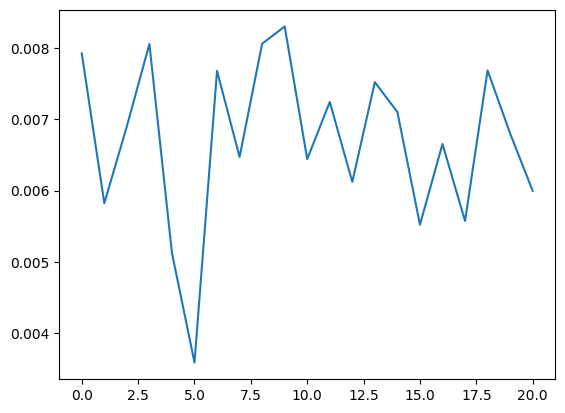

In [25]:
total_loss_series = pd.Series(total_loss_lt)
total_loss_series.plot.line()

## Validation

In [ ]:
def generate_seq(model, tokenizer, input):
    generated_ids = model.generate(**input)
    generated_text = tokenizer.decode(generated_ids.squeeze(0), skip_special_tokens=True)
    
    return generated_text

def generate_input_target(model, tokenizer, input, label):
    input_text = tokenizer.decode(input['input_ids'].squeeze(0), skip_special_tokens=True)
    generated_text = generate_seq(model, tokenizer, input)
    target_text = tokenizer.decode(label.squeeze(0), skip_special_tokens=True)
    
    return {
        'input_text': input_text,
        'generated_text': generated_text, 
        'target_text': target_text
    }

def generate_from_data(model, tokenizer, data):
    label = data['labels']
    input_data = dict()
    input_data['input_ids'] = data['input_ids']
    input_data['attention_mask'] = data['attention_mask']

    return generate_input_target(model, tokenizer, input_data, label)

def eval(model, tokenizer, input_seq, label, metric, options = dict()):
    generated_input_target = generate_input_target(model, tokenizer, input_seq, label)
    score = metric.compute(
        generated_input_target['generated_text'], 
        generated_input_target['target_text'],
        **options
    )

    return score

In [49]:
validset = tokenized_dataset['valid'].with_format("torch", device=device)
test_sample = validset.shuffle().select(range(1))
print(test_sample['input_ids'].shape)
output = generate_from_data(model, tokenizer, test_sample)

print(output['input_text'], output['generated_text'], output['target_text'], sep='\n\n')

맞춰입어보는 것도

맞춰 입어 보는 것도

맞춰 입어 보는 것도


In [ ]:
accuracy_lt = []
bleu_score_lt = []
rouge_score_lt = []
accuracy = evaluate.load('accuracy')
bleu = evaluate.load('google_bleu')
rouge = Rouge()

for example in tqdm(validset.shuffle().select(range(2000))):
    data = dict()
    for key in example:
        data[key] = example[key].unsqueeze(0)
    output = generate_from_data(model, tokenizer, data)
    generated_text = output['generated_text']
    target_text = output['target_text']

    try:
        bleu_score = sentence_bleu([target_text], generated_text, smoothing_function=SmoothingFunction().method1)
        rouge_score = rouge.get_scores(generated_text, target_text)[0]['rouge-2']['f']
    except ValueError:
        continue

    bleu_score_lt.append(bleu_score)
    rouge_score_lt.append(rouge_score)

bleu_score_series = pd.Series(bleu_score_lt)
rouge_score_series = pd.Series(rouge_score_lt)
print(bleu_score_series.mean(), rouge_score_series.mean(), sep='\t')
result_df = pd.concat([bleu_score_series, rouge_score_series], axis=1)

## Saving

In [ ]:
# To prevent unwanted saves
raise RuntimeError

In [ ]:
NOW_STR = datetime.datetime.now().strftime('%y%m%d-%H:%M')
trainer.create_model_card(
    language='Korean',
    tags='Grammar',
    #model='KoGrammar',
    finetuned_from=checkpoint
)
trainer.save_model(f"drive/MyDrive/projects/KoGrammar/models/{NOW_STR}")